In [1]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mdates
import numpy as np

# Load your data
df = pd.read_csv("15MIN-Updated.csv", parse_dates=["DateTime"])
df.set_index("DateTime", inplace=True)

In [2]:
def build_rsi_plot(df):
    """Return addplots for RSI (main line + levels) if RSI column exists."""
    if "RSI" not in df.columns:
        return []
    return [
        mpf.make_addplot(df["RSI"], panel=1, color="blue", ylabel="RSI"),
        mpf.make_addplot(np.full(len(df), 70), panel=1, color="red", linestyle="--"),
        mpf.make_addplot(np.full(len(df), 30), panel=1, color="purple", linestyle="--")
    ]

In [3]:
def build_signal_arrows(df):
    """Return scatter arrows for CrossSignal (+1 buy, -1 sell) if column exists."""
    if "CrossSignal" not in df.columns:
        return []

    buy_series = np.where(df["CrossSignal"] == 1, df["Low"] * 0.995, np.nan)
    sell_series = np.where(df["CrossSignal"] == -1, df["High"] * 1.005, np.nan)

    return [
        mpf.make_addplot(buy_series, type="scatter", marker="^", color="green", markersize=100, panel=0),
        mpf.make_addplot(sell_series, type="scatter", marker="v", color="red", markersize=100, panel=0)
    ]

In [4]:
import logging
from typing import Union, List, Tuple
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import numpy as np

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def draw_signal_lines(
    df: pd.DataFrame,
    axes: Union[Axes, List[Axes], Tuple[Axes, ...]],
    signal_col: str = "CrossSignal",
    buy_color: str = "green",
    sell_color: str = "red",
    linestyle: str = "--",
    linewidth: float = 1.5,
    alpha: float = 0.8,
    zorder: int = 0
) -> None:
    """
    Draw full-height vertical lines for buy/sell signals on a matplotlib/mplfinance candlestick chart.

    Args:
        df (pd.DataFrame): DataFrame with a datetime index and a signal column.
        axes (Union[Axes, List[Axes], Tuple[Axes, ...]]): Matplotlib Axes object(s) from mplfinance.plot(returnfig=True).
        signal_col (str, optional): Name of the column containing buy (1) or sell (-1) signals. Defaults to "CrossSignal".
        buy_color (str, optional): Color for buy signals. Defaults to "green".
        sell_color (str, optional): Color for sell signals. Defaults to "red".
        linestyle (str, optional): Line style for vertical lines. Defaults to "--".
        linewidth (float, optional): Width of the vertical lines. Defaults to 1.5.
        alpha (float, optional): Transparency of the vertical lines (0 to 1). Defaults to 0.8.
        zorder (int, optional): Z-order for line drawing (lower values are drawn behind). Defaults to 0.

    Raises:
        ValueError: If input parameters are invalid or signal column is missing.
        TypeError: If input types are incorrect.

    Returns:
        None
    """
    # Input validation
    if not isinstance(df, pd.DataFrame):
        raise TypeError("df must be a pandas DataFrame")
    if signal_col not in df.columns:
        raise ValueError(f"Signal column '{signal_col}' not found in DataFrame")
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a DatetimeIndex")
    if not isinstance(axes, (Axes, list, tuple)):
        raise TypeError("axes must be a matplotlib Axes object or a list/tuple of Axes")
    if isinstance(axes, (list, tuple)) and not axes:
        raise ValueError("Axes list/tuple cannot be empty")
    if not (0 <= alpha <= 1):
        raise ValueError("alpha must be between 0 and 1")
    if not isinstance(linewidth, (int, float)) or linewidth <= 0:
        raise ValueError("linewidth must be a positive number")

    # Ensure axes is a single Axes object
    ax = axes[0] if isinstance(axes, (list, tuple)) else axes

    # Validate signal values
    valid_signals = {-1, 1}
    signals = df[signal_col].dropna()
    if not signals.isin(valid_signals).all():
        invalid_signals = signals[~signals.isin(valid_signals)].unique()
        logger.warning(f"Invalid signal values found: {invalid_signals}. Only 1 (buy) and -1 (sell) are processed.")

    # Optimize by pre-computing indices and signals
    signal_data = [(df.index.get_loc(dt), signal) for dt, signal in zip(df.index, df[signal_col])
                   if pd.notna(signal) and signal in valid_signals]
    if not signal_data:
        logger.info("No valid signals found to plot.")
        return

    # Get y-axis limits
    ymin, ymax = ax.get_ylim()

    # Plot all lines in a single call for better performance
    indices, signals = zip(*signal_data)
    colors = [buy_color if s == 1 else sell_color for s in signals]

    try:
        ax.vlines(
            x=indices,
            ymin=ymin,
            ymax=ymax,
            colors=colors,
            linestyles=linestyle,
            linewidth=linewidth,
            alpha=alpha,
            zorder=zorder
        )
        logger.info(f"Successfully plotted {len(signal_data)} signal lines")
    except Exception as e:
        logger.error(f"Error plotting signal lines: {str(e)}")
        raise

    # Ensure axes limits are preserved
    ax.set_ylim(ymin, ymax)

In [5]:
def plot_candles(df):
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    addplots = []
    addplots.extend(build_rsi_plot(df))
    addplots.extend(build_signal_arrows(df))

    fig, axes = mpf.plot(
        df,
        type='candle',
        style='classic',
        volume=False,
        figratio=(14, 7),
        figscale=1.2,
        returnfig=True,
        addplot=addplots
    )

    axes[0].set_title("Candlestick Chart")
    return fig , axes


INFO:__main__:Successfully plotted 7 signal lines


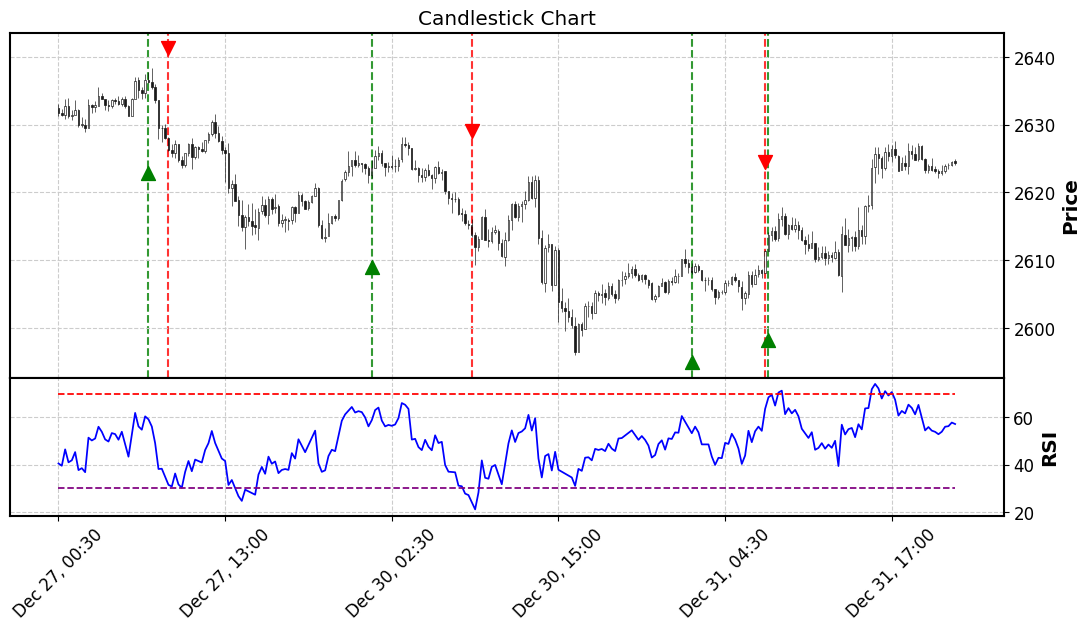

In [6]:
fig, axes = plot_candles(df);
draw_signal_lines(df, axes, signal_col="CrossSignal", buy_color="green", sell_color="red")
plt.show()